In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('superstore.csv')

In [4]:
df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [5]:
df['Order Date']=pd.to_datetime(df['Order Date'])
df['Ship Date']=pd.to_datetime(df['Ship Date'])
df['Date Diff']=(df['Ship Date']-df['Order Date'])

In [6]:
df['Order Date']=df['Order Date'].dt.to_period('M')

In [7]:
grouped=df.groupby('State')['Sales'].sum().reset_index().sort_values('Sales',ascending=False)
grouped['Mean']=grouped['Sales'].mean()
grouped['CumSum']=(grouped['Sales']/grouped['Sales'].sum()*100).cumsum()
#grouped

In [8]:
fig=make_subplots(specs=[[{'secondary_y':True}]])
trace1=go.Bar(name='Sales',x=grouped['State'],y=grouped['Sales'],text=grouped['Sales'])
trace2=go.Line(name='Cumulative Sales Percentage',x=grouped['State'],y=grouped['CumSum'])
trace3=go.Line(name='Mean Sales',x=grouped['State'],y=grouped['Mean'])

fig.add_trace(trace1,secondary_y=False)
fig.add_trace(trace3,secondary_y=False)
fig.add_trace(trace2,secondary_y=True)

fig.update_layout(title_text='Sales by State',width=1200,height=600)
fig.update_xaxes(title_text='State')
fig.update_traces(marker=dict(color=grouped['Sales'],colorscale='Blues'),secondary_y=False)
fig.update_traces(marker=dict(color='black'),secondary_y=True)
#fig.write_html(r'C:\Users\berid\OneDrive\Desktop\plotly.html')
fig.show()

C:\Users\berid\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [9]:
#px.choropleth(grouped,locations='State',scope='usa',color='Sales')
iso=pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')[0]
iso['Code']=iso['Code'].str.split('-').str[-1].str.strip()
iso=iso[['Subdivision name (en)','Code']]
iso.columns=['State','iso']
grouped=grouped.merge(iso,on='State')

In [10]:
fig=px.choropleth(grouped,
              locations='iso',
              locationmode="USA-states",
              scope='usa',
              color='Sales',
             color_continuous_scale='Blues',hover_name='State')
fig.update_layout(title_text='Sales by State')
#fig.write_html(r'C:\Users\berid\OneDrive\Desktop\plotly_choropleth.html')
fig.show()

In [11]:
import geopandas
import matplotlib.pyplot as plt

In [12]:
cities=geopandas.read_file(r"C:\Users\berid\python\geopandas\tl_2022_us_cities\tl_2022_us_county.shp")
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\s_22mr22_states\s_22mr22.shp")

In [13]:
states['States_long']=states['geometry'].centroid.x
states['States_lat']=states['geometry'].centroid.y

In [14]:
cities['Long']=cities['geometry'].centroid.x
cities['Lat']=cities['geometry'].centroid.y
cities=cities[['STATEFP','NAME','Long','Lat']]
cities=cities.merge(states[['FIPS','NAME','States_long','States_lat']],left_on='STATEFP',right_on='FIPS')

In [19]:
grouped=df.groupby(['State','City'])['Sales'].mean().reset_index()
grouped=grouped.merge(cities,left_on=['State','City'],right_on=['NAME_y','NAME_x'])

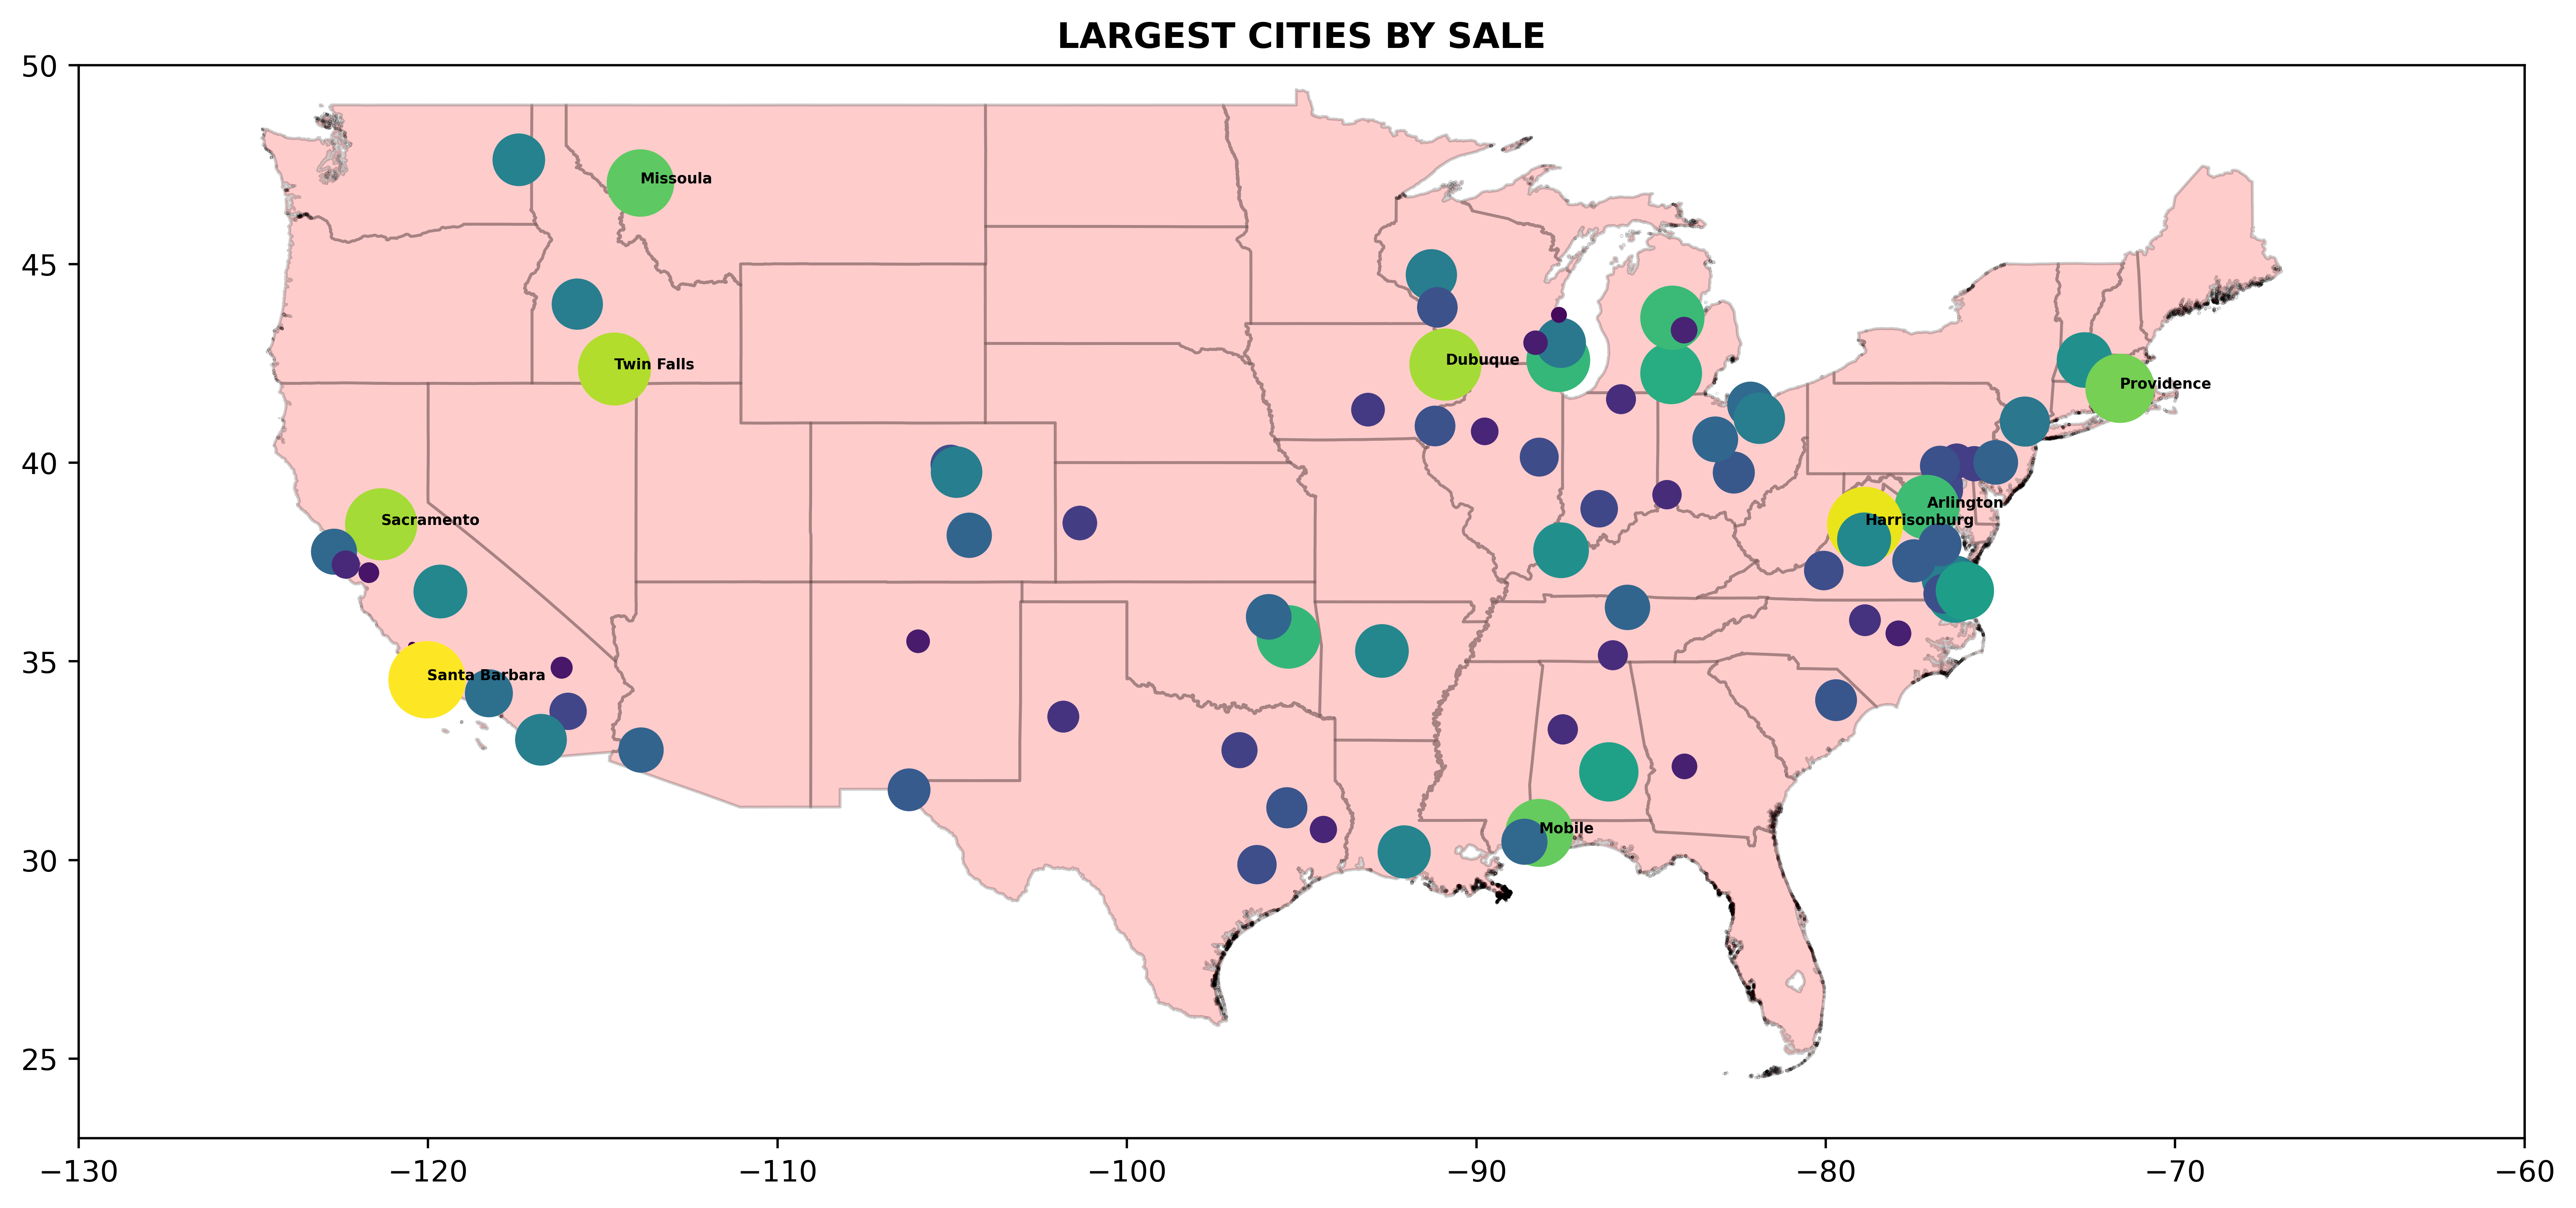

In [20]:
fig,ax=plt.subplots(figsize=(15,10),dpi=500)
ax=states.plot(ax=ax,color='red',ec='black',alpha=0.2)
ax.scatter(x=grouped['Long'],y=grouped['Lat'],s=grouped['Sales'],c=grouped['Sales'])
plt.title('LARGEST CITIES BY SALE',fontweight='bold')
plt.xlim(-130,-60)
plt.ylim(23,50)
for i in range(len(grouped)):
    #ax.text(grouped['States_long'][i],grouped['States_lat'][i],grouped['NAME_y'][i],fontweight='bold',size=5)
    if grouped['Sales'][i]>grouped['Sales'].quantile(0.9):
        ax.text(grouped['Long'][i],grouped['Lat'][i],grouped['City'][i],fontweight='bold',size=5)
    else:
        None
plt.show()

In [17]:
grouped=df.groupby(['Category','Sub-Category'])['Sales'].sum().reset_index().sort_values(['Category','Sales'],ascending=[True,False])
grouped['CumSales']=grouped.groupby('Category')['Sales'].transform(lambda x:(x/x.sum()*100).cumsum())

In [18]:
fig=make_subplots(rows=2,cols=2,
                  specs=[[{'secondary_y':True} for i in range(2)] for j in range(2)],
                  subplot_titles=[cat for cat in grouped['Category'].unique()],
                
                 )

for i,cat in enumerate(grouped['Category'].unique(),start=1):
    filtered=grouped[grouped['Category']==cat]
    
    trace1=go.Bar(x=filtered['Sub-Category'],y=filtered['Sales'],name='Sales')
    trace2=go.Line(x=filtered['Sub-Category'],y=filtered['CumSales'],name='Cumulative Sales')
    
    fig.add_trace(trace1,row=math.ceil(i/2),col=math.ceil(i%2)+1 if i<grouped['Category'].nunique() else 1,secondary_y=False)
    fig.add_trace(trace2,row=math.ceil(i/2),col=math.ceil(i%2)+1 if i<grouped['Category'].nunique() else 1,secondary_y=True)
    
    fig.update_traces(marker=dict(color=grouped['Sales'],colorscale='Blues'),secondary_y=False)
    fig.update_traces(marker=dict(color='black'),secondary_y=True)

fig.update_layout(font=dict(family="Arial",size=10))
fig.show()

C:\Users\berid\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


